In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#%% Prepare dataset

# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Reshape
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Model / data parameters
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1::]

In [3]:
#%% Prepare data for siamese network
def prepare_dataset(x, y, n=num_classes):
    # Select 10 samples for each class
    classes = np.unique(y_train)
    cls_dict = dict()
    for cls in classes:
        cls_idx = np.argwhere(y_train == cls).reshape(-1, )
        cls_idx = np.random.choice(cls_idx, n)
        cls_dict[cls] = cls_idx

    x_pos = list()
    x_neg = list()
    for cls in classes:
        a = x_train[cls_dict[cls][0]]

        # Positive samples
        for idx, elem in enumerate(cls_dict[cls]):
            if idx > 0:
                b = x_train[elem]
                x_pos.append((a, b))

        # Negative samples
        for temp in classes:
            if temp == cls:
                continue

            random_idx = np.random.choice(cls_dict[temp], int(num_classes/n))
            b = np.squeeze(x_train[random_idx], axis=0)
            x_neg.append((a, b))

    x_pos_arr = np.array(x_pos)
    x_neg_arr = np.array(x_neg)
    y_pos = np.ones(shape=len(x_pos_arr))
    y_neg = np.zeros(shape=len(x_neg_arr))

    siam_inputs = np.append(x_pos_arr, x_neg_arr, axis=0)
    siam_labels = np.append(y_pos, y_neg)

    # Shuffle
    shuffle_idx = np.arange(len(siam_inputs))
    np.random.shuffle(shuffle_idx)
    siam_inputs = siam_inputs[shuffle_idx]
    siam_labels = siam_labels[shuffle_idx].astype(np.int32)
    
    return siam_inputs, siam_labels

siam_inputs, siam_labels = prepare_dataset(x_train, y_train, n=10)
siam_inputs_v, siam_labels_v = prepare_dataset(x_test, y_test, n=10)

0


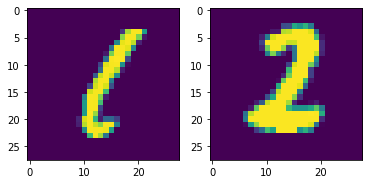

In [4]:
IDX = np.random.randint(0, len(siam_labels))
print(siam_labels[IDX])

plt.figure()
plt.subplot(1,2,1)
plt.imshow(siam_inputs[IDX, 0])
plt.subplot(1,2,2)
plt.imshow(siam_inputs[IDX, 1])

In [5]:
#%% Create model for extracting feature vector
def create_embedding(embedding_size):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape)(inputs)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(embedding_size, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(embedding_size, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="embedding")
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='Adam',
        metrics=['accuracy'])
    
    #%% Train embedding model
    batch_size = 256
    epochs = 50

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True
    )

    history = model.fit(x_train, 
                        y_train, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        callbacks=[earlystop],
                        use_multiprocessing=True,
                        verbose=True,
                        validation_data=(x_test, y_test))
    
    # Extract pretrained model for embedding
    emb_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)
    for layer in emb_model.layers:
        layer.trainable = False
    
    return emb_model

embedding = create_embedding(embedding_size=64)
print(embedding.summary())

Epoch 1/50
235/235 [==============================] - 5s 8ms/step - loss: 2.7111 - accuracy: 0.3468 - val_loss: 0.7660 - val_accuracy: 0.7791
Epoch 2/50
235/235 [==============================] - 1s 6ms/step - loss: 0.9588 - accuracy: 0.6918 - val_loss: 0.3398 - val_accuracy: 0.9144
Epoch 3/50
235/235 [==============================] - 1s 6ms/step - loss: 0.6316 - accuracy: 0.8073 - val_loss: 0.2392 - val_accuracy: 0.9406
Epoch 4/50
235/235 [==============================] - 1s 6ms/step - loss: 0.4866 - accuracy: 0.8571 - val_loss: 0.1846 - val_accuracy: 0.9519
Epoch 5/50
235/235 [==============================] - 1s 6ms/step - loss: 0.3946 - accuracy: 0.8830 - val_loss: 0.1504 - val_accuracy: 0.9601
Epoch 6/50
235/235 [==============================] - 1s 6ms/step - loss: 0.3363 - accuracy: 0.9004 - val_loss: 0.1273 - val_accuracy: 0.9629
Epoch 7/50
235/235 [==============================] - 1s 6ms/step - loss: 0.3011 - accuracy: 0.9090 - val_loss: 0.1202 - val_accuracy: 0.9676
Epoch 

In [6]:
#%% Embedding test
# Get some samples with label 7
idx7 = np.argwhere(y_test == 7)[:5].reshape(-1, )
emb_idx7 = embedding.predict(x_test[idx7])

idx8 = np.argwhere(y_test == 8)[:5].reshape(-1, )
emb_idx8 = embedding.predict(x_test[idx8])

# Positive example
dp = np.sqrt(np.sum(np.square(emb_idx7[0] - emb_idx7[3])))
print("Positive embedding distance: {}".format(dp))

# Negative example
dn = np.sqrt(np.sum(np.square(emb_idx7[0] - emb_idx8[3])))
print("Negative embedding distance: {}".format(dn))

Positive embedding distance: 6.711926460266113
Negative embedding distance: 49.85800552368164


In [7]:
#%% Create Siamese model
input_image = tf.keras.Input(shape=input_shape)
ref_image = tf.keras.Input(shape=input_shape)

input_emb = embedding(input_image)
ref_emb = embedding(ref_image)

distance = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(input_emb - ref_emb), keepdims=True))
distance = tf.keras.layers.Lambda(lambda x: x / 1000)(distance)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(distance)

siamese = tf.keras.Model(inputs=[input_image, ref_image], outputs=outputs, name="siamese")

siamese.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

print(siamese.summary())

Model: "siamese"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 64)           17008       input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
tf.math.subtract (TFOpLambda)   (None, 64)           0           model[0][0]                

In [8]:
#%% Training
batch_size = 1
epochs = 100

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

history = siamese.fit([siam_inputs[:, 0], siam_inputs[:, 1]], 
                    siam_labels, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    callbacks=[earlystop],
                    use_multiprocessing=True,
                    validation_data=([siam_inputs_v[:, 0], siam_inputs_v[:, 1]], siam_labels_v),
                    verbose=True)

Epoch 1/100
180/180 [==============================] - 2s 9ms/step - loss: 0.6995 - accuracy: 0.5000 - val_loss: 0.7053 - val_accuracy: 0.4778
Epoch 2/100
180/180 [==============================] - 1s 7ms/step - loss: 0.7012 - accuracy: 0.4778 - val_loss: 0.7048 - val_accuracy: 0.4056
Epoch 3/100
180/180 [==============================] - 1s 7ms/step - loss: 0.6996 - accuracy: 0.4889 - val_loss: 0.7045 - val_accuracy: 0.3722
Epoch 4/100
180/180 [==============================] - 1s 7ms/step - loss: 0.6989 - accuracy: 0.4778 - val_loss: 0.7042 - val_accuracy: 0.3167
Epoch 5/100
180/180 [==============================] - 1s 7ms/step - loss: 0.6994 - accuracy: 0.4944 - val_loss: 0.7038 - val_accuracy: 0.1611
Epoch 6/100
180/180 [==============================] - 1s 7ms/step - loss: 0.7000 - accuracy: 0.3444 - val_loss: 0.7034 - val_accuracy: 0.1333
Epoch 7/100
180/180 [==============================] - 1s 7ms/step - loss: 0.6987 - accuracy: 0.3778 - val_loss: 0.7030 - val_accuracy: 0.1111

Epoch 58/100
180/180 [==============================] - 1s 7ms/step - loss: 0.6902 - accuracy: 0.5444 - val_loss: 0.6873 - val_accuracy: 0.8611
Epoch 59/100
180/180 [==============================] - 1s 7ms/step - loss: 0.6898 - accuracy: 0.5333 - val_loss: 0.6870 - val_accuracy: 0.8611
Epoch 60/100
180/180 [==============================] - 1s 7ms/step - loss: 0.6897 - accuracy: 0.5389 - val_loss: 0.6867 - val_accuracy: 0.9111
Epoch 61/100
180/180 [==============================] - 1s 7ms/step - loss: 0.6896 - accuracy: 0.5111 - val_loss: 0.6863 - val_accuracy: 0.8889
Epoch 62/100
180/180 [==============================] - 1s 7ms/step - loss: 0.6898 - accuracy: 0.5667 - val_loss: 0.6860 - val_accuracy: 0.9333
Epoch 63/100
180/180 [==============================] - 1s 7ms/step - loss: 0.6895 - accuracy: 0.5667 - val_loss: 0.6857 - val_accuracy: 0.9333
Epoch 64/100
180/180 [==============================] - 1s 7ms/step - loss: 0.6894 - accuracy: 0.6000 - val_loss: 0.6855 - val_accuracy:

<-> For (8, 1), validation is False
<+> For (8, 8), validation is True


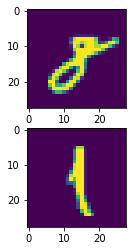

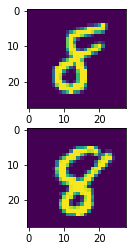

In [9]:
def isSame(siamese, labels: tuple):
    input_val = labels[0]
    ref_val = labels[1]
    
    # Select random sample from test case
    input_val_idx = np.argwhere(y_test == input_val).reshape(-1, )
    input_val_idx = np.random.choice(input_val_idx, 1)
    ref_val_idx = np.argwhere(y_test == ref_val).reshape(-1, )
    ref_val_idx = np.random.choice(ref_val_idx, 1)
    
    # Predict
    input_image = x_test[input_val_idx]
    ref_image = x_test[ref_val_idx]
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.imshow(np.squeeze(input_image))
    plt.subplot(2, 1, 2)
    plt.imshow(np.squeeze(ref_image))
    prediction = siamese.predict([input_image, ref_image])
    return (prediction > 0.5).item()

vals = (np.random.randint(0, 10), np.random.randint(0, 10))
print("<-> For {}, validation is {}".format(vals, isSame(siamese, vals)))

a = np.random.randint(0, 10)
vals = (a, a)
print("<+> For {}, validation is {}".format(vals, isSame(siamese, vals)))